<a href="https://colab.research.google.com/github/ayumu-1212/tabelog_analysis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torchvision
from torchvision import models
import torch.nn as nn

In [ ]:
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# プログレスバー導入
from tqdm import tqdm
import time

In [ ]:
# 店舗ごとに画像を読み込むように設定
# 標準化検討
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, label_path, transform=None):
        x = []
        y = []
        
        with open (label_path, 'r') as infh:
            header = next(infh)
            line_index = 0
            three_imgs = []
            for line in infh:
                line_index += 1
                d = line.replace('\n', "").split(",")
                three_imgs.append(os.path.join(os.path.dirname(label_path), d[0]))
                if line_index % 3 == 0:
                    x.append(three_imgs)
                    three_imgs = []
                    if d[1] == '':
                        y.append(float(0))
                    else:
                        y.append(float(d[1]))
        
        self.x = x
        self.y = torch.from_numpy(np.array(y)).float().view(-1, 1)
        
        self.transform = transform
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        img0 = PIL.Image.open(self.x[i][0]).convert("RGB")
        img1 = PIL.Image.open(self.x[i][1]).convert("RGB")
        img2 = PIL.Image.open(self.x[i][2]).convert("RGB")
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return img0, img1, img2, self.y[i]

In [ ]:
from torchvision.transforms.transforms import Resize
normalize = torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    normalize
])

data_dir = "./drive/MyDrive/Colab Notebooks/CATechAccel/data/train_labels_20220223054616.csv"
full_dataset = MyDataset(data_dir, transform=transform)

# # 店舗ごとに分けられるように
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
valid_size = len(full_dataset) - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, valid_size]
)

# # print(f"full: {len(full_dataset)} -> train: {len(train_dataset)}, test: {len(val_dataset)}")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# 1店舗(3画像)1スコアでの出力
arch = "resnet50"
resnet_model = models.__dict__[arch](pretrained=True)

# 最後のfc層を削除（Identity()に変更）
resnet_model.fc = nn.Identity()

for p in resnet_model.parameters(): 
#   print("p:{}\n".format(p))
  p.requires_grad=False

In [ ]:
class CustomNet(torch.nn.Module):
    
    def __init__(self):
        super(CustomNet, self).__init__()

        self.sigmoid = torch.nn.Sigmoid()

        self.fc1 = torch.nn.Linear(3 * 2048, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1)
        
    def forward(self, x):
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 3, 320, 320])

        x = x.view(-1, 3 * 2048) # 多次元から1次元に無理やり戻しすぎ
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # sigmoid関数を使って0 - 1の値に変換する
        x = self.sigmoid(x)
        
        return x

custom_model = CustomNet()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
custom_model = custom_model.to(device)
resnet_model = resnet_model.to(device)

In [ ]:
# test
resnet_model.train()

data = next(iter(train_loader))
img0, img1, img2, labels = data
labels /= 5
img0 = img0.to(device)
img1 = img1.to(device)
img2 = img2.to(device)
labels = labels.to(device)
# optimizer.zero_grad()
output0 = resnet_model(img0)
output1 = resnet_model(img1)
output2 = resnet_model(img2)
torch.stack((output0, output1, output2), 1).size()

torch.Size([64, 3, 2048])

In [ ]:
optimizer = torch.optim.SGD(custom_model.parameters(), lr=0.01)

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

criterion = RMSELoss()


# criterion = torch.nn.RMSELoss()

In [ ]:
train_loss = []
valid_loss = []

for epoch in tqdm(range(50)):
  # 学習
#  そもそも勾配変化がしないのでなしでいい
#   resnet_model.train()
  custom_model.train()
  running_train_loss = 0.0
  with torch.set_grad_enabled(True):
    for data in train_loader:
      # custom_modelに入れ込む↓
      img0, img1, img2, labels = data
      # ↓の式は前処理 or custom_modelに入れ込む
      labels /= 5
      img0 = img0.to(device)
      img1 = img1.to(device)
      img2 = img2.to(device)
      labels = labels.to(device)
      output0 = resnet_model(img0)
      output1 = resnet_model(img1)
      output2 = resnet_model(img2)
      outputs = torch.stack((output0, output1, output2), 1)
      
      outputs = custom_model(outputs)
      # torch.Size([64, 3, 2048])
      loss = criterion(outputs, labels)
      # print("loss.item():{}\n".format(loss.item()))
      running_train_loss += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    #   print(outputs)

  train_loss.append(running_train_loss / len(train_dataset))
  
  # 検証
#   resnet_model.eval()
  custom_model.eval()
  running_valid_loss = 0.0
  with torch.set_grad_enabled(False):
    for data in valid_loader:

      img0, img1, img2, labels = data
      labels /= 5
      img0 = img0.to(device)
      img1 = img1.to(device)
      img2 = img2.to(device)
      labels = labels.to(device)
      output0 = resnet_model(img0)
      output1 = resnet_model(img1)
      output2 = resnet_model(img2)
      outputs = torch.stack((output0, output1, output2), 1)
      outputs = custom_model(outputs)
      # print("loss.item():{}\n".format(loss.item()))
      running_valid_loss += loss.item()

  valid_loss.append(running_valid_loss / len(valid_dataset))
#   print('#epoch:{}\ttrain loss: {}'.format(epoch, running_train_loss / len(train_loss)))
  print('#epoch:{}\ttrain loss: {}\tvalid loss: {}'.format(epoch,
                                                running_train_loss / len(train_loss), 
                                                running_valid_loss / len(valid_loss)))

  2%|▏         | 1/50 [00:19<15:42, 19.24s/it]

#epoch:0	train loss: 0.09624232596252114	valid loss: 0.007605471648275852


  4%|▍         | 2/50 [00:38<15:19, 19.16s/it]

#epoch:1	train loss: 0.05116735416231677	valid loss: 0.030421726405620575


  6%|▌         | 3/50 [00:57<14:57, 19.10s/it]

#epoch:2	train loss: 0.03428729483857751	valid loss: 0.02070555090904236


  8%|▊         | 4/50 [01:16<14:35, 19.03s/it]

#epoch:3	train loss: 0.02518471091752872	valid loss: 0.013422215357422829


 10%|█         | 5/50 [01:35<14:16, 19.03s/it]

#epoch:4	train loss: 0.020077119977213443	valid loss: 0.011254015564918517


 12%|█▏        | 6/50 [01:54<14:00, 19.10s/it]

#epoch:5	train loss: 0.015736421977635473	valid loss: 0.0014838950398067634


 14%|█▍        | 7/50 [02:13<13:44, 19.17s/it]

#epoch:6	train loss: 0.013306530890986323	valid loss: 0.000648433475622109


 16%|█▌        | 8/50 [02:33<13:25, 19.17s/it]

#epoch:7	train loss: 0.011672720225760713	valid loss: 0.0011311190901324153


 18%|█▊        | 9/50 [02:52<13:07, 19.21s/it]

#epoch:8	train loss: 0.010947344229660101	valid loss: 0.006264327300919427


 20%|██        | 10/50 [03:11<12:49, 19.23s/it]

#epoch:9	train loss: 0.009148222021758556	valid loss: 0.0007563411258161068


 22%|██▏       | 11/50 [03:30<12:29, 19.22s/it]

#epoch:10	train loss: 0.008329832809977233	valid loss: 0.0005758010189641606


 24%|██▍       | 12/50 [03:50<12:10, 19.21s/it]

#epoch:11	train loss: 0.0076245073093256606	valid loss: 0.0003126703668385744


 26%|██▌       | 13/50 [04:09<11:51, 19.23s/it]

#epoch:12	train loss: 0.006957441326588965	valid loss: 0.0005851588570154631


 28%|██▊       | 14/50 [04:28<11:34, 19.29s/it]

#epoch:13	train loss: 0.006491900055802294	valid loss: 0.0006039499172142573


 30%|███       | 15/50 [04:47<11:15, 19.29s/it]

#epoch:14	train loss: 0.006023254742225011	valid loss: 0.00046697473153471946


 32%|███▏      | 16/50 [05:07<10:56, 19.30s/it]

#epoch:15	train loss: 0.005568177097302396	valid loss: 0.000360586418537423


 34%|███▍      | 17/50 [05:26<10:33, 19.20s/it]

#epoch:16	train loss: 0.005553355454193319	valid loss: 0.0033163255190148074


 36%|███▌      | 18/50 [05:45<10:14, 19.20s/it]

#epoch:17	train loss: 0.0049336542853982085	valid loss: 0.0002893575777610143


 38%|███▊      | 19/50 [06:05<09:58, 19.30s/it]

#epoch:18	train loss: 0.00496082188022372	valid loss: 0.0026877026416753467


 40%|████      | 20/50 [06:24<09:38, 19.27s/it]

#epoch:19	train loss: 0.004386346286628396	valid loss: 0.0002397270640358329


 42%|████▏     | 21/50 [06:43<09:17, 19.22s/it]

#epoch:20	train loss: 0.004465185416241487	valid loss: 0.0024810202774547393


 44%|████▍     | 22/50 [07:02<08:58, 19.23s/it]

#epoch:21	train loss: 0.004241830637593838	valid loss: 0.002400743859735402


 46%|████▌     | 23/50 [07:21<08:39, 19.23s/it]

#epoch:22	train loss: 0.004029743920039871	valid loss: 0.002283929158811984


 48%|████▊     | 24/50 [07:41<08:21, 19.29s/it]

#epoch:23	train loss: 0.004122960487923895	valid loss: 0.004365221286813418


 50%|█████     | 25/50 [08:00<08:02, 19.29s/it]

#epoch:24	train loss: 0.003475893852300942	valid loss: 0.0003471853956580162


 52%|█████▏    | 26/50 [08:19<07:42, 19.26s/it]

#epoch:25	train loss: 0.0032947806220573303	valid loss: 0.00015648329057372533


 54%|█████▍    | 27/50 [08:39<07:23, 19.28s/it]

#epoch:26	train loss: 0.0031661658625428877	valid loss: 0.00016866679544802064


 56%|█████▌    | 28/50 [08:58<07:03, 19.24s/it]

#epoch:27	train loss: 0.003044193103310785	valid loss: 0.00027862189537180323


 58%|█████▊    | 29/50 [09:17<06:45, 19.29s/it]

#epoch:28	train loss: 0.003140559223287835	valid loss: 0.0017409966937426862


 60%|██████    | 30/50 [09:37<06:26, 19.34s/it]

#epoch:29	train loss: 0.002812299923971295	valid loss: 0.00018903521510461966


 62%|██████▏   | 31/50 [09:56<06:05, 19.25s/it]

#epoch:30	train loss: 0.0029236332686137286	valid loss: 0.0017975014784643727


 64%|██████▍   | 32/50 [10:15<05:46, 19.24s/it]

#epoch:31	train loss: 0.0026276444805262145	valid loss: 0.0001955237239599228


 66%|██████▌   | 33/50 [10:34<05:26, 19.22s/it]

#epoch:32	train loss: 0.0026887825718431763	valid loss: 0.0014829237126942837


 68%|██████▊   | 34/50 [10:53<05:07, 19.21s/it]

#epoch:33	train loss: 0.002445163855822209	valid loss: 0.00014803016229587442


 70%|███████   | 35/50 [11:12<04:47, 19.18s/it]

#epoch:34	train loss: 0.002390454593114555	valid loss: 0.00017111006059816907


 72%|███████▏  | 36/50 [11:32<04:28, 19.21s/it]

#epoch:35	train loss: 0.0024794505443423986	valid loss: 0.0013607855265339215


 74%|███████▍  | 37/50 [11:51<04:09, 19.20s/it]

#epoch:36	train loss: 0.002231484920893972	valid loss: 0.00012607014159093032


 76%|███████▌  | 38/50 [12:10<03:50, 19.21s/it]

#epoch:37	train loss: 0.0021741233036951407	valid loss: 0.0001562802782772403


 78%|███████▊  | 39/50 [12:29<03:31, 19.21s/it]

#epoch:38	train loss: 0.0022720826091244817	valid loss: 0.0014052562033518767


 80%|████████  | 40/50 [12:49<03:12, 19.25s/it]

#epoch:39	train loss: 0.002205829878221266	valid loss: 0.0013106543570756911


 82%|████████▏ | 41/50 [13:08<02:53, 19.27s/it]

#epoch:40	train loss: 0.002255718581514751	valid loss: 0.0023881335084031266


 84%|████████▍ | 42/50 [13:27<02:34, 19.28s/it]

#epoch:41	train loss: 0.0019390961831612956	valid loss: 0.00017576613685204868


 86%|████████▌ | 43/50 [13:47<02:15, 19.31s/it]

#epoch:42	train loss: 0.0018915785909738652	valid loss: 0.0001333884483333244


 88%|████████▊ | 44/50 [14:06<01:56, 19.36s/it]

#epoch:43	train loss: 0.0018557690835388546	valid loss: 0.000166255874897946


 90%|█████████ | 45/50 [14:25<01:36, 19.30s/it]

#epoch:44	train loss: 0.0020533992081052726	valid loss: 0.0021474407778845892


 92%|█████████▏| 46/50 [14:45<01:17, 19.31s/it]

#epoch:45	train loss: 0.0017252224497497082	valid loss: 0.00010351271813978319


 94%|█████████▍| 47/50 [15:04<00:57, 19.30s/it]

#epoch:46	train loss: 0.0019505576384154723	valid loss: 0.0019133858224178882


 96%|█████████▌| 48/50 [15:24<00:38, 19.44s/it]

#epoch:47	train loss: 0.0016835484008576411	valid loss: 0.00016627326840534806


 98%|█████████▊| 49/50 [15:43<00:19, 19.33s/it]

#epoch:48	train loss: 0.0017444952391088009	valid loss: 0.0010917021759918758


100%|██████████| 50/50 [16:02<00:00, 19.24s/it]

#epoch:49	train loss: 0.0016950528346933425	valid loss: 0.0009371867775917053


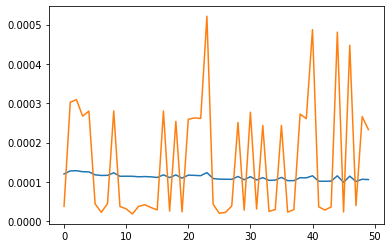

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(train_loss, label='train')
ax.plot(valid_loss, label='valid')
fig.show()

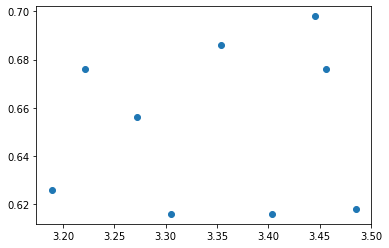

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
outputs *= 5
ax.scatter(outputs.cpu().detach().numpy(), labels.cpu().detach().numpy())
fig.show()

- 重みは更新しない（->p.requires_grad=False）
- 回帰問題にするために、out_features=1に設定
- dataloaderのときにNormalizeを変更、画像サイズも調整 -> h:224, w:224

In [ ]:
class RegressionNet(torch.nn.Module):
    
    def __init__(self):
        super(RegressionNet, self).__init__()
        
        self.relu = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(32 * 78 * 78, 1024)
        self.fc2 = torch.nn.Linear(1024, 1024)
        self.fc3 = torch.nn.Linear(1024, 1)
        
    def forward(self, x):
        # x = torch.nn.functional.relu(self.conv1(x))
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 3, 320, 320])
        x = self.conv1(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 318, 318])
        x = self.relu(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 318, 318])
        x = self.pool1(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 16, 159, 159])
        # x = torch.nn.functional.relu(self.conv2(x))
        x = self.conv2(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 157, 157])
        x = self.relu(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 157, 157])
        x = self.pool2(x)
        # print(torch.Tensor.size(x))
        # -> torch.Size([64, 32, 78, 78])

        x = x.view(-1, 32 * 78 * 78) # 多次元から1次元に無理やり戻しすぎ
        x = self.relu(x) # 別の活性化関数に変更（tanhなど）
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        print("x:{}".format(x))
        # sigmoid関数を使って0 - 1の値に変換する
        
        return x

In [ ]:
# 1画像1スコアでの出力
arch = "resnet50"
model = models.__dict__[arch](pretrained=True)

# 最後のfc層だけout_features=1に変更
# model.fc = nn.Linear(model.fc.in_features, 1)
# Add Sigmoid
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)

for p in model.parameters(): 
#   print("p:{}\n".format(p))
  p.requires_grad=False

# fc層とbiasだけ学習はさせる
model.fc[0].weight.requires_grad=True
model.fc[0].bias.requires_grad=True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# model.train()

# data = next(iter(train_loader))
# inputs, labels = data
# labels /= 5
# inputs = inputs.to(device)
# labels = labels.to(device)
# # optimizer.zero_grad()
# outputs = model(inputs)

In [ ]:
# test
model.train()

data = next(iter(train_loader))
img0, img1, img2, labels = data
labels /= 5
img0 = img0.to(device)
img1 = img1.to(device)
img2 = img2.to(device)
labels = labels.to(device)
# optimizer.zero_grad()
outputs = model(img0)